In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # CRITICAL: This was missing
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import box_iou, nms  # Use torchvision's implementations
from pycocotools.coco import COCO
from PIL import Image
from tqdm import tqdm
import os

In [19]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from pycocotools.coco import COCO
import torch.nn.functional as F
import torchvision.ops as ops


class BCCDDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = root_dir
        self.split = split  # 'train', 'val', or 'test'
        self.img_dir = os.path.join(root_dir, split)
        self.ann_file = os.path.join(self.img_dir, "_annotations.coco.json")
        self.coco = COCO(self.ann_file)
        self.img_ids = list(self.coco.imgs.keys())
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]

        img_path = os.path.join(self.img_dir, img_info["file_name"])
        image = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        for ann in anns:
            bbox = ann["bbox"]  # COCO format: [x, y, width, height]
            x, y, w, h = bbox
            boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
            labels.append(ann["category_id"])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id])
        }

        if self.transform:
            image = self.transform(image)

        return image, target


In [20]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Define basic transform
basic_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Paths
train_json = "/Users/rohith/Desktop/NIT_ROURKELA/Datasets/coco_json/BCCD/train/_annotations.coco.json"
val_json = "/Users/rohith/Desktop/NIT_ROURKELA/Datasets/coco_json/BCCD/valid/_annotations.coco.json"
test_json = "/Users/rohith/Desktop/NIT_ROURKELA/Datasets/coco_json/BCCD/test/_annotations.coco.json"

# Image directories
train_img_dir = "/Users/rohith/Desktop/NIT_ROURKELA/Datasets/coco_json/BCCD/train"
val_img_dir = "/Users/rohith/Desktop/NIT_ROURKELA/Datasets/coco_json/BCCD/valid"
test_img_dir = "/Users/rohith/Desktop/NIT_ROURKELA/Datasets/coco_json/BCCD/test"

# Create dataset instances
train_dataset = BCCDDataset(root_dir="/Users/rohith/Desktop/NIT_ROURKELA/Datasets/coco_json/BCCD", split="train", transform=basic_transform)
val_dataset = BCCDDataset(root_dir="/Users/rohith/Desktop/NIT_ROURKELA/Datasets/coco_json/BCCD", split="valid", transform=basic_transform)
test_dataset = BCCDDataset(root_dir="/Users/rohith/Desktop/NIT_ROURKELA/Datasets/coco_json/BCCD", split="test", transform=basic_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


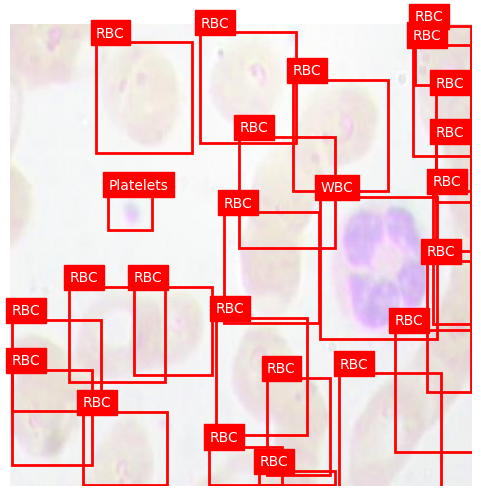

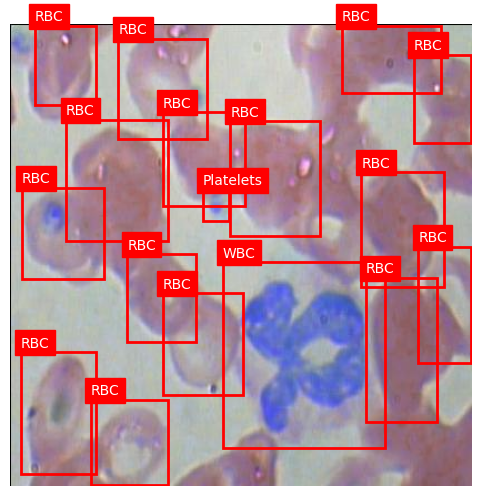

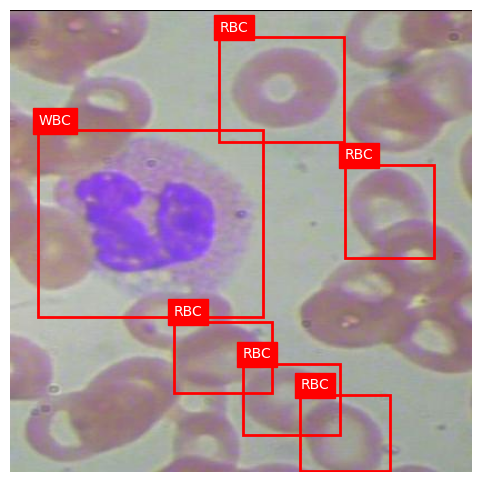

In [21]:
import matplotlib.pyplot as plt

# Example: one batch from train_loader
images, targets = next(iter(train_loader))

import torchvision.transforms.functional as F
import matplotlib.patches as patches

def visualize_sample(image, target, category_map):
    # Convert image tensor to PIL for visualization
    image = F.to_pil_image(image)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    ax = plt.gca()
    
    boxes = target['boxes']
    labels = target['labels']
    
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, category_map[label.item()], color='white', backgroundcolor='red')
    
    plt.axis('off')
    plt.show()

    # You need a map from label index to class name (e.g., {1: 'RBC', 2: 'WBC', 3: 'Platelets'})
category_map = {
    1: 'Platelets',
    2: 'RBC',
    3: 'WBC'
}

for i in range(3):  # visualize 3 samples
    visualize_sample(images[i], targets[i], category_map)

In [22]:
import torch
import torch.nn as nn
from model import DWSConv, SE, CondConv, DeformableConv, CBAM

class ObjectDetector(nn.Module):
    """Complete Object Detection Model combining Backbone, Neck, and Head"""
    
    def __init__(self, num_classes=3, reg_max=16):
        super().__init__()
        self.num_classes = num_classes
        self.reg_max = reg_max
        
        # Initialize components
        self.backbone = CustomBackbone()
        self.neck = CustomNeck(in_channels=[64, 128, 256], out_channels=128)  # Fixed channels
        self.head = DetectHead(channels=[128, 128, 128], num_classes=num_classes, reg_max=reg_max)
        
        # Store strides for later use
        self.strides = [8, 16, 32]
    
    def forward(self, x):
        # Get features from backbone
        c3, c4, c5 = self.backbone(x)
        
        # Process through neck
        features = self.neck(c3, c4, c5)  # [p3, p4, p5]
        
        # Get predictions from head
        predictions = self.head(features)
        
        return predictions

class CustomBackbone(nn.Module):
    """Fixed Custom Backbone"""
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            DWSConv(3, 32, k=3, s=2),    # /2
            DWSConv(32, 48, k=3, s=2),   # /4
            DWSConv(48, 64, k=3, s=2),   # /8 (C3) - idx 2
            SE(64),                      # idx 3
            DWSConv(64, 128, k=3, s=2),  # /16 (C4) - idx 4
            SE(128),                     # idx 5
            CondConv(128, 256, k=3, s=2), # /32 (C5) - idx 6
            SE(256),                     # idx 7
            DeformableConv(256, 512, k=3, s=2), # /64 - idx 8
            CBAM(512),                   # idx 9
            DeformableConv(512, 512, k=3, s=1), # idx 10
            CBAM(512)                    # idx 11
        ])
        self.stride = 64
        
    def forward(self, x):
        outputs = []
        for layer in self.layers:
            x = layer(x)
            outputs.append(x)
        
        # Return features at correct indices
        # C3 (stride 8): outputs[2] - 64 channels
        # C4 (stride 16): outputs[4] - 128 channels  
        # C5 (stride 32): outputs[6] - 256 channels
        return outputs[2], outputs[4], outputs[6]

class CustomNeck(nn.Module):
    """Fixed Custom Neck with correct input channels"""
    def __init__(self, in_channels=[64, 128, 256], out_channels=128):  # Fixed input channels
        super().__init__()

        # 1x1 conv to reduce channels
        self.reduce_conv_c3 = nn.Conv2d(in_channels[0], out_channels, 1, 1, 0)
        self.reduce_conv_c4 = nn.Conv2d(in_channels[1], out_channels, 1, 1, 0)
        self.reduce_conv_c5 = nn.Conv2d(in_channels[2], out_channels, 1, 1, 0)

        # Fusion convolutions (after concat)
        self.fuse_p4 = nn.Conv2d(out_channels * 2, out_channels, 3, 1, 1)
        self.fuse_p3 = nn.Conv2d(out_channels * 2, out_channels, 3, 1, 1)

    def forward(self, c3, c4, c5):
        # Reduce channels
        p3 = self.reduce_conv_c3(c3)
        p4 = self.reduce_conv_c4(c4)
        p5 = self.reduce_conv_c5(c5)

        # Top-down fusion
        p5_upsampled = F.interpolate(p5, scale_factor=2, mode="nearest")
        p4 = self.fuse_p4(torch.cat([p4, p5_upsampled], dim=1))

        p4_upsampled = F.interpolate(p4, scale_factor=2, mode="nearest")
        p3 = self.fuse_p3(torch.cat([p3, p4_upsampled], dim=1))

        return [p3, p4, p5]  # All have 128 channels

class DetectHead(nn.Module):
    """Fixed Detection Head"""
    def __init__(self, channels, num_classes, reg_max=16):
        super().__init__()
        self.num_classes = num_classes
        self.reg_max = reg_max

        self.stems = nn.ModuleList()
        self.cls_convs = nn.ModuleList()
        self.reg_convs = nn.ModuleList()

        for ch in channels:
            self.stems.append(nn.Sequential(
                nn.Conv2d(ch, ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(ch),
                nn.SiLU()
            ))
            self.cls_convs.append(nn.Conv2d(ch, num_classes, 1))  # Classification
            self.reg_convs.append(nn.Conv2d(ch, 4 * reg_max, 1))  # Regression (DFL)

    def forward(self, features):
        outputs = []
        for x, stem, cls_conv, reg_conv in zip(features, self.stems, self.cls_convs, self.reg_convs):
            x = stem(x)
            cls_out = cls_conv(x)  # [B, num_classes, H, W]
            reg_out = reg_conv(x)  # [B, 4*reg_max, H, W]
            
            # Combine outputs
            B, _, H, W = cls_out.shape
            reg_out = reg_out.view(B, 4, self.reg_max, H, W)  # [B, 4, reg_max, H, W]
            
            # Concatenate along channel dimension
            out = torch.cat([reg_out.flatten(1, 2), cls_out], dim=1)  # [B, 4*reg_max + num_classes, H, W]
            outputs.append(out)
        return outputs


In [23]:
import torch
import torch.nn.functional as F

class PredictionDecoder:
    def __init__(self, num_classes, strides, device='cpu', reg_max=16):
        """
        Args:
            num_classes (int): Number of classes.
            strides (list[int]): Stride values corresponding to each feature map level.
            device (str or torch.device): Device to run the decoding on.
            reg_max (int): Maximum regression bins for DFL.
        """
        self.num_classes = num_classes
        self.strides = strides
        self.device = torch.device(device)
        self.reg_max = reg_max
        self.project = torch.linspace(0, self.reg_max - 1, self.reg_max).to(self.device)
        self.grids = [None] * len(strides)  # One grid per feature map level
    def decode_box(self, pred):
        """Convert DFL outputs to boxes"""
        pred = pred.softmax(dim=1)
        return (pred * self.project.to(pred.device)).sum(dim=1)
    def _make_grid(self, nx, ny, i):
        """Create a grid of shape (1, ny, nx, 2) for feature map i."""
        yv, xv = torch.meshgrid([torch.arange(ny), torch.arange(nx)])
        grid = torch.stack((xv, yv), 2).to(self.device).float()  # (ny, nx, 2)
        return grid  # shape: (ny, nx, 2)

    def decode_single(self, preds, stride, grid=None):
        """
        Decode predictions for a single feature level.
        
        Args:
            preds: Tensor of shape (B, C, H, W), where C = 4 + num_classes
            stride: int, stride value for this feature map
            grid: precomputed grid tensor (H, W, 2)
        
        Returns:
            Tensor of shape (B, H*W, 4 + num_classes) with decoded boxes and class probs
        """
        B, C, H, W = preds.shape
        num_classes = self.num_classes
        assert C == 4 + num_classes, f"Expected channels {4 + num_classes}, got {C}"

        if grid is None or grid.shape[0] != H or grid.shape[1] != W:
            grid = self._make_grid(W, H, 0)

        preds = preds.permute(0, 2, 3, 1).contiguous()  # (B, H, W, C)
        preds = preds.view(B, -1, C)  # (B, H*W, C)

        # Split preds into bbox and class
        bbox_pred = preds[:, :, :4]
        cls_pred = preds[:, :, 4:]

        # bbox decoding (anchor-free)
        # x_center, y_center = sigmoid(tx, ty) + grid
        # width, height = exp(tw, th)
        xy = torch.sigmoid(bbox_pred[:, :, :2]) + grid.view(1, -1, 2)  # (B, H*W, 2)
        wh = torch.exp(bbox_pred[:, :, 2:4])  # (B, H*W, 2)
    
        # scale to image size by stride
        xy = xy * stride
        wh = wh * stride

        # convert to x1, y1, x2, y2
        x1y1 = xy - wh / 2
        x2y2 = xy + wh / 2
        boxes = torch.cat([x1y1, x2y2], dim=2)  # (B, H*W, 4)

        # class probabilities
        cls_probs = torch.sigmoid(cls_pred)  # (B, H*W, num_classes)

        return torch.cat([boxes, cls_probs], dim=2)  # (B, H*W, 4 + num_classes)

    def __call__(self, preds):
        """
        Decode predictions from all feature levels.

        Args:
            preds (list[Tensor]): List of predictions per scale,
                                  each with shape (B, C, H, W)

        Returns:
            Tensor of shape (B, N, 4 + num_classes) where
            N = sum of all (H*W) across scales.
        """
        assert len(preds) == len(self.strides), "Number of preds must equal number of strides"

        decoded = []
        for i, pred in enumerate(preds):
            if self.grids[i] is None or self.grids[i].shape[0] != pred.shape[2] or self.grids[i].shape[1] != pred.shape[3]:
                self.grids[i] = self._make_grid(pred.shape[3], pred.shape[2], i).to(self.device)
            decoded.append(self.decode_single(pred, self.strides[i], self.grids[i]))

        return torch.cat(decoded, dim=1)  # concat on all spatial points
    


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------
# Focal Loss for classification
# ---------------------------
def sigmoid_focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction="none"):
    """
    Focal Loss for binary classification.
    inputs: logits [N, C]
    targets: one-hot encoded labels [N, C]
    """
    prob = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = prob * targets + (1 - prob) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    else:
        return loss

# ---------------------------
# CIoU Box Loss
# ---------------------------
def bbox_iou_ciou(box1, box2, eps=1e-7):
    """
    Compute Complete IoU between two sets of boxes.
    box1, box2: [N, 4] in (x1,y1,x2,y2) format
    Returns: [N] ciou loss
    """
    inter_x1 = torch.max(box1[:, 0], box2[:, 0])
    inter_y1 = torch.max(box1[:, 1], box2[:, 1])
    inter_x2 = torch.min(box1[:, 2], box2[:, 2])
    inter_y2 = torch.min(box1[:, 3], box2[:, 3])
    inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)

    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    union = area1 + area2 - inter_area + eps

    iou = inter_area / union

    # Center distance
    center_x1 = (box1[:, 0] + box1[:, 2]) / 2
    center_y1 = (box1[:, 1] + box1[:, 3]) / 2
    center_x2 = (box2[:, 0] + box2[:, 2]) / 2
    center_y2 = (box2[:, 1] + box2[:, 3]) / 2
    center_dist = (center_x1 - center_x2) ** 2 + (center_y1 - center_y2) ** 2

    # Enclosing box
    enclose_x1 = torch.min(box1[:, 0], box2[:, 0])
    enclose_y1 = torch.min(box1[:, 1], box2[:, 1])
    enclose_x2 = torch.max(box1[:, 2], box2[:, 2])
    enclose_y2 = torch.max(box1[:, 3], box2[:, 3])
    enclose_diag = (enclose_x2 - enclose_x1) ** 2 + (enclose_y2 - enclose_y1) ** 2 + eps

    # Aspect ratio term
    w1 = box1[:, 2] - box1[:, 0]
    h1 = box1[:, 3] - box1[:, 1]
    w2 = box2[:, 2] - box2[:, 0]
    h2 = box2[:, 3] - box2[:, 1]

    v = (4 / (3.141592653589793 ** 2)) * torch.pow(torch.atan(w2 / (h2 + eps)) - torch.atan(w1 / (h1 + eps)), 2)
    with torch.no_grad():
        alpha = v / (1 - iou + v + eps)

    ciou = iou - (center_dist / enclose_diag) - alpha * v
    return ciou.clamp(-1.0, 1.0)

# ---------------------------
# Distribution Focal Loss
# ---------------------------
class DFL(nn.Module):
    """Distribution Focal Loss (DFL) for bounding box regression"""
    
    def __init__(self, reg_max=16):
        super().__init__()
        self.reg_max = reg_max
        self.project = torch.arange(reg_max, dtype=torch.float)

    def forward(self, pred, target):
        """
        pred: [N, reg_max] - predicted distribution
        target: [N] - target distance values in range [0, reg_max-1]
        """
        device = pred.device
        self.project = self.project.to(device)
        
        # Clamp target to valid range
        target = target.clamp(0, self.reg_max - 1)
        
        # Get left and right integer positions
        target_left = target.long()
        target_right = (target_left + 1).clamp(max=self.reg_max - 1)
        
        # Calculate weights for interpolation
        weight_right = target - target_left.float()
        weight_left = 1 - weight_right
        
        # Compute cross entropy losses
        loss_left = F.cross_entropy(pred, target_left, reduction='none')
        loss_right = F.cross_entropy(pred, target_right, reduction='none')
        
        # Weighted combination
        total_loss = loss_left * weight_left + loss_right * weight_right
        
        return total_loss.mean()

class ImprovedDetectionLoss(nn.Module):
    """Improved Detection Loss with proper integration"""
    
    def __init__(self, num_classes, reg_max=16):
        super().__init__()
        self.num_classes = num_classes
        self.reg_max = reg_max
        self.project = torch.arange(reg_max, dtype=torch.float)
        
    def forward(self, predictions, targets, strides):
        """
        predictions: List of tensors [B, 4*reg_max + num_classes, H, W]
        targets: List of dicts with 'boxes' and 'labels'
        strides: List of stride values [8, 16, 32]
        """
        device = predictions[0].device
        self.project = self.project.to(device)
        
        total_loss = 0.0
        num_pos = 0
        
        for pred, stride in zip(predictions, strides):
            B, C, H, W = pred.shape
            
            # Split predictions
            reg_pred = pred[:, :4*self.reg_max, :, :].reshape(B, 4, self.reg_max, H, W)
            cls_pred = pred[:, 4*self.reg_max:, :, :].reshape(B, self.num_classes, H, W)
            
            # Generate grid
            grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
            grid = torch.stack([grid_x, grid_y], dim=-1).to(device).float()
            grid = grid * stride + stride // 2  # Center of each grid cell
            
            # Assign targets for this scale
            scale_loss, scale_num_pos = self._compute_scale_loss(
                reg_pred, cls_pred, grid, targets, stride, H, W
            )
            
            total_loss += scale_loss
            num_pos += scale_num_pos
        
        return total_loss / max(num_pos, 1)
    
    def _compute_scale_loss(self, reg_pred, cls_pred, grid, targets, stride, H, W):
        """Compute loss for a single scale"""
        B = reg_pred.shape[0]
        device = reg_pred.device
        
        # Initialize loss
        cls_loss = 0.0
        reg_loss = 0.0
        num_pos = 0
        
        for b in range(B):
            target = targets[b]
            gt_boxes = target['boxes']  # [N, 4] in xyxy format
            gt_labels = target['labels']  # [N]
            
            if len(gt_boxes) == 0:
                continue
                
            # Simple positive assignment: assign GT to closest grid cell
            gt_centers = (gt_boxes[:, :2] + gt_boxes[:, 2:]) / 2  # [N, 2]
            
            # Find closest grid cells
            grid_flat = grid.view(-1, 2)  # [H*W, 2]
            distances = torch.cdist(gt_centers, grid_flat)  # [N, H*W]
            _, closest_indices = distances.min(dim=1)  # [N]
            
            # Convert to grid coordinates
            closest_y = closest_indices // W
            closest_x = closest_indices % W
            
            # Create targets
            cls_target = torch.zeros(self.num_classes, H, W, device=device)
            reg_target = torch.zeros(4, H, W, device=device)
            pos_mask = torch.zeros(H, W, device=device, dtype=torch.bool)
            
            for i, (gx, gy, label) in enumerate(zip(closest_x, closest_y, gt_labels)):
                if 0 <= gx < W and 0 <= gy < H:
                    cls_target[label-1, gy, gx] = 1.0  # One-hot encoding
                    
                    # Regression targets (simplified)
                    gt_box = gt_boxes[i]
                    center = grid[gy, gx]
                    reg_target[:2, gy, gx] = (gt_box[:2] - center).abs() / stride  # Distance to top-left
                    reg_target[2:, gy, gx] = (gt_box[2:] - center).abs() / stride  # Distance to bottom-right
                    
                    pos_mask[gy, gx] = True
                    num_pos += 1
            
            # Compute losses
            # Classification loss (focal loss)
            cls_pred_b = cls_pred[b].sigmoid()
            cls_loss += sigmoid_focal_loss(cls_pred[b], cls_target, reduction='sum')
            
            # Regression loss (only on positive samples)
            if pos_mask.sum() > 0:
                reg_pred_b = reg_pred[b]  # [4, reg_max, H, W]
                reg_pred_pos = reg_pred_b[:, :, pos_mask]  # [4, reg_max, num_pos]
                reg_target_pos = reg_target[:, pos_mask]  # [4, num_pos]
                
                # Convert DFL predictions to values
                reg_pred_decoded = (reg_pred_pos.softmax(dim=1) * self.project.view(1, -1, 1)).sum(dim=1)
                
                # L1 loss for regression
                reg_loss += F.l1_loss(reg_pred_decoded, reg_target_pos, reduction='sum')
        
        return cls_loss + reg_loss, num_pos



In [25]:
import torch
from tqdm import tqdm

def train_one_epoch(model, train_loader, optimizer, loss_fn, device, epoch, print_freq=10):
    """Fixed training loop"""
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}")

    for i, (images, targets) in pbar:
        # Prepare data
        images = torch.stack(images).to(device)  # Stack images into batch
        
        # Prepare targets
        batch_targets = []
        for target in targets:
            batch_targets.append({
                'boxes': target['boxes'].to(device),
                'labels': target['labels'].to(device)
            })

        optimizer.zero_grad()

        # Forward pass
        predictions = model(images)  # List of [B, 4*reg_max + num_classes, H, W]
        
        # Compute loss
        total_loss = loss_fn(predictions, batch_targets, model.strides)

        # Backward pass
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

        if (i + 1) % print_freq == 0:
            pbar.set_postfix({'loss': running_loss / (i + 1)})

    return running_loss / len(train_loader)


# Helper methods needed for the training loop
def _make_grid(self, H, W, stride, device):
    """Generate grid coordinates for anchor-free decoding"""
    yv, xv = torch.meshgrid([torch.arange(H), torch.arange(W)])
    grid = torch.stack((xv, yv), 2).to(device).float() * stride + stride // 2
    return grid.view(-1, 2)  # [H*W, 2]

def decode_boxes(self, pred, grid, stride):
    """Convert DFL predictions to boxes"""
    B, N, _ = pred.shape
    pred = pred.view(B, N, 4, -1).softmax(-1)  # [B, H*W, 4, reg_max]
    box_pred = torch.matmul(pred, self.project.to(pred.device))  # DFL
    boxes = torch.cat([
        (grid[:, 0:1] + box_pred[..., 0:1] * stride),  # x
        (grid[:, 1:2] + box_pred[..., 1:2] * stride),  # y
        torch.exp(box_pred[..., 2:3]) * stride,        # w
        torch.exp(box_pred[..., 3:4]) * stride         # h
    ], dim=-1)
    return boxes  # [B, H*W, 4] (ltrb format)

In [26]:
def validate_one_epoch(model, val_loader, loss_fn, device, feature_map_shapes, strides, num_classes, epoch):
    """Validate the model for one epoch and return validation loss."""
    model.eval()
    running_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for images, targets in val_loader:
            # Prepare data
            images = torch.stack(images).to(device)
            
            # Prepare targets
            batch_targets = []
            for target in targets:
                batch_targets.append({
                    'boxes': target['boxes'].to(device),
                    'labels': target['labels'].to(device)
                })
            
            # Forward pass
            predictions = model(images)
            
            # Compute loss
            loss = loss_fn(predictions, batch_targets, strides)
            
            running_loss += loss.item()
            num_batches += 1
    
    return running_loss / max(num_batches, 1)


In [27]:
def post_process_predictions(predictions, strides=[8, 16, 32], conf_threshold=0.25, 
                           iou_threshold=0.45, max_detections=300, num_classes=3, reg_max=16):
    """Improved post-processing with better error handling"""
    if not predictions or len(predictions) == 0:
        return []
        
    device = predictions[0].device
    batch_size = predictions[0].shape[0]
    project = torch.arange(reg_max, dtype=torch.float, device=device)
    batch_detections = []
    
    for batch_idx in range(batch_size):
        all_boxes = []
        all_scores = []
        all_labels = []
        
        for pred, stride in zip(predictions, strides):
            pred_single = pred[batch_idx:batch_idx+1]
            B, C, H, W = pred_single.shape
            
            # Validate input dimensions
            expected_channels = 4 * reg_max + num_classes
            if C != expected_channels:
                print(f"Warning: Expected {expected_channels} channels, got {C}")
                continue
            
            # Split predictions with error checking
            try:
                reg_pred = pred_single[:, :4*reg_max, :, :].reshape(1, 4, reg_max, H, W)
                cls_pred = pred_single[:, 4*reg_max:, :, :].reshape(1, num_classes, H, W)
            except Exception as e:
                print(f"Error in prediction splitting: {e}")
                continue
            
            # Decode predictions
            cls_scores = torch.sigmoid(cls_pred).squeeze(0)
            reg_pred_softmax = reg_pred.softmax(dim=2)
            reg_decoded = (reg_pred_softmax * project.view(1, 1, -1, 1, 1)).sum(dim=2).squeeze(0)
            
            # Create grid and decode boxes
            grid_y, grid_x = torch.meshgrid(torch.arange(H, device=device), 
                                          torch.arange(W, device=device), indexing='ij')
            grid = torch.stack([grid_x, grid_y], dim=0).float()
            xy = (grid + 0.5) * stride
            
            x1 = xy[0] - reg_decoded[0] * stride
            y1 = xy[1] - reg_decoded[1] * stride
            x2 = xy[0] + reg_decoded[2] * stride
            y2 = xy[1] + reg_decoded[3] * stride
            
            boxes = torch.stack([x1, y1, x2, y2], dim=0).reshape(4, -1).transpose(0, 1)
            cls_scores = cls_scores.reshape(num_classes, -1).transpose(0, 1)
            
            max_scores, max_labels = cls_scores.max(dim=1)
            keep = max_scores > conf_threshold
            
            if keep.sum() > 0:
                all_boxes.append(boxes[keep])
                all_scores.append(max_scores[keep])
                all_labels.append(max_labels[keep])
        
        # Combine and apply NMS
        if len(all_boxes) > 0:
            final_boxes = torch.cat(all_boxes, dim=0)
            final_scores = torch.cat(all_scores, dim=0)
            final_labels = torch.cat(all_labels, dim=0)
            
            # Apply class-wise NMS
            final_keep = []
            for class_id in range(num_classes):
                class_mask = final_labels == class_id
                if class_mask.sum() > 0:
                    class_boxes = final_boxes[class_mask]
                    class_scores = final_scores[class_mask]
                    
                    # Apply NMS
                    try:
                        nms_keep = nms(class_boxes, class_scores, iou_threshold)
                        original_indices = torch.where(class_mask)[0][nms_keep]
                        final_keep.append(original_indices)
                    except Exception as e:
                        print(f"NMS error for class {class_id}: {e}")
                        continue
            
            if len(final_keep) > 0:
                final_keep = torch.cat(final_keep)
                if len(final_keep) > max_detections:
                    _, sort_idx = final_scores[final_keep].sort(descending=True)
                    final_keep = final_keep[sort_idx[:max_detections]]
                
                batch_detections.append({
                    'boxes': final_boxes[final_keep],
                    'scores': final_scores[final_keep],
                    'labels': final_labels[final_keep]
                })
            else:
                batch_detections.append({
                    'boxes': torch.empty((0, 4), device=device),
                    'scores': torch.empty((0,), device=device),
                    'labels': torch.empty((0,), dtype=torch.long, device=device)
                })
        else:
            batch_detections.append({
                'boxes': torch.empty((0, 4), device=device),
                'scores': torch.empty((0,), device=device),
                'labels': torch.empty((0,), dtype=torch.long, device=device)
            })
    
    return batch_detections


In [28]:



def assign_targets_anchor_free(
    gt_boxes,             # (B, M, 4) absolute coords
    gt_classes,           # (B, M)
    feature_map_shapes,   # [(H1, W1), (H2, W2), (H3, W3)]
    strides,              # [s1, s2, s3]
    num_classes,
    ignore_index=-1,
    center_radius=0.2
):
    """
    Assign targets to anchor-free points on multiple scales.

    Returns lists of:
      target_boxes: (B, H*W, 4)
      target_classes: (B, H*W)
      positive_masks: (B, H*W) bool
      ignore_masks: (B, H*W) bool
    """
    B, M, _ = gt_boxes.shape
    S = len(feature_map_shapes)

    target_boxes = []
    target_classes = []
    positive_masks = []
    ignore_masks = []

    for scale_idx, (H, W) in enumerate(feature_map_shapes):
        stride = strides[scale_idx]
        N = H * W

        tb = torch.zeros((B, N, 4), device=gt_boxes.device, dtype=torch.float32)
        tc = torch.full((B, N), ignore_index, device=gt_boxes.device, dtype=torch.long)
        pm = torch.zeros((B, N), device=gt_boxes.device, dtype=torch.bool)
        im = torch.zeros((B, N), device=gt_boxes.device, dtype=torch.bool)

        grid_x = (torch.arange(W, device=gt_boxes.device) + 0.5) * stride
        grid_y = (torch.arange(H, device=gt_boxes.device) + 0.5) * stride
        gy, gx = torch.meshgrid(grid_y, grid_x, indexing='ij')
        gx = gx.reshape(-1)
        gy = gy.reshape(-1)

        for b in range(B):
            for m in range(M):
                cls = gt_classes[b, m]
                if cls == ignore_index:
                    continue
                box = gt_boxes[b, m]
                x1, y1, x2, y2 = box
                if x2 <= x1 or y2 <= y1:
                    continue

                cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
                bw, bh = x2 - x1, y2 - y1

                r = center_radius
                x1c, x2c = cx - r * bw / 2, cx + r * bw / 2
                y1c, y2c = cy - r * bh / 2, cy + r * bh / 2

                inside_pos = (gx >= x1c) & (gx <= x2c) & (gy >= y1c) & (gy <= y2c)
                inside_full = (gx >= x1) & (gx <= x2) & (gy >= y1) & (gy <= y2)

                if inside_pos.sum() == 0:
                    continue

                # Only assign positives if not assigned yet
                if pm[b, inside_pos].any():
                    mask = inside_pos & (~pm[b])
                else:
                    mask = inside_pos

                tb[b, mask] = box
                tc[b, mask] = cls
                pm[b, mask] = True

                ignore_area = inside_full & (~inside_pos)
                im[b, ignore_area] = True

        target_boxes.append(tb)
        target_classes.append(tc)
        positive_masks.append(pm)
        ignore_masks.append(im)

    return target_boxes, target_classes, positive_masks, ignore_masks

In [29]:
def print_metrics_summary(metrics, class_names):
    print(f"\n{'Class':10} {'Images':>6} {'Instances':>9} {'P':>8} {'R':>8} {'mAP50':>8} {'mAP50-95':>10}")
    for i, cname in enumerate(class_names):
        stats = metrics.get(i, None)
        if stats is None or stats['num_instances'] == 0:
            continue
        print(f"{cname:10} {0:6} {stats['num_instances']:9} "
              f"{stats['P']:.3f} {stats['R']:.3f} {stats['mAP50']:.3f} {stats['mAP50-95']:.3f}")
    # Overall
    all_stats = metrics['all']
    print(f"{'all':10} {0:6} {all_stats['num_instances']:9} "
          f"{all_stats['P']:.3f} {all_stats['R']:.3f} {all_stats['mAP50']:.3f} {all_stats['mAP50-95']:.3f}")

In [30]:
import numpy as np
import numpy as np
import torch

def compute_metrics_map(predictions, ground_truths, num_classes):
    iou_thresholds = np.arange(0.5, 1.0, 0.05)  # 0.5 to 0.95 step 0.05

    class_stats = {}
    total_instances = 0

    for c in range(num_classes):
        # Gather preds and gts for class c
        class_preds = []
        class_gts = []
        npos = 0

        for pred, gt in zip(predictions, ground_truths):
            pred_mask = pred['labels'] == c
            gt_mask = gt['labels'] == c

            pred_boxes = pred['boxes'][pred_mask]
            pred_scores = pred['scores'][pred_mask] if 'scores' in pred else torch.ones_like(pred_boxes[:, 0])
            gt_boxes = gt['boxes'][gt_mask]

            npos += gt_boxes.size(0)
            class_gts.append(gt_boxes)

            for pb, ps in zip(pred_boxes, pred_scores):
                class_preds.append({'box': pb, 'score': ps.item() if isinstance(ps, torch.Tensor) else ps})

        if npos == 0:
            class_stats[c] = {'P': 0, 'R': 0, 'mAP50': 0, 'mAP50-95': 0, 'num_instances': 0}
            continue

        class_preds = sorted(class_preds, key=lambda x: x['score'], reverse=True)

        tp = np.zeros(len(class_preds))
        fp = np.zeros(len(class_preds))
        detected = [False] * npos

        gt_boxes_concat = torch.cat(class_gts) if class_gts else torch.empty((0, 4))
        total_instances += npos

        for i, pred in enumerate(class_preds):
            pred_box = pred['box'].unsqueeze(0)
            if gt_boxes_concat.size(0) == 0:
                fp[i] = 1
                continue

            # FIXED: Handle the scalar case properly
            ious_tensor = box_iou(pred_box, gt_boxes_concat)  # Shape: [1, N]
            ious = ious_tensor.cpu().numpy().flatten()  # Flatten to 1D array
            
            if len(ious) == 0:
                fp[i] = 1
                continue
                
            max_iou_idx = np.argmax(ious)
            max_iou = ious[max_iou_idx]  # Now safe to index

            if max_iou > 0.5 and not detected[max_iou_idx]:
                tp[i] = 1
                detected[max_iou_idx] = True
            else:
                fp[i] = 1

        # Rest of the function remains the same...
        fp_cum = np.cumsum(fp)
        tp_cum = np.cumsum(tp)
        recall = tp_cum / npos
        precision = tp_cum / (tp_cum + fp_cum + 1e-16)

        ap50 = compute_ap(recall, precision)

        # mAP 0.5:0.95 calculation
        aps = []
        for iou_thresh in iou_thresholds:
            tp_iou = np.zeros(len(class_preds))
            fp_iou = np.zeros(len(class_preds))
            detected_iou = [False] * npos

            for i, pred in enumerate(class_preds):
                pred_box = pred['box'].unsqueeze(0)
                if gt_boxes_concat.size(0) == 0:
                    fp_iou[i] = 1
                    continue

                ious_tensor = box_iou(pred_box, gt_boxes_concat)
                ious = ious_tensor.cpu().numpy().flatten()
                
                if len(ious) == 0:
                    fp_iou[i] = 1
                    continue
                    
                max_iou_idx = np.argmax(ious)
                max_iou = ious[max_iou_idx]

                if max_iou > iou_thresh and not detected_iou[max_iou_idx]:
                    tp_iou[i] = 1
                    detected_iou[max_iou_idx] = True
                else:
                    fp_iou[i] = 1

            fp_cum_iou = np.cumsum(fp_iou)
            tp_cum_iou = np.cumsum(tp_iou)
            recall_iou = tp_cum_iou / npos
            precision_iou = tp_cum_iou / (tp_cum_iou + fp_cum_iou + 1e-16)
            aps.append(compute_ap(recall_iou, precision_iou))

        mAP50_95 = np.mean(aps)

        # Final precision & recall (take last values if available)
        P = precision[-1] if precision.size > 0 else 0
        R = recall[-1] if recall.size > 0 else 0

        class_stats[c] = {'P': P, 'R': R, 'mAP50': ap50, 'mAP50-95': mAP50_95, 'num_instances': npos}

    # Compute overall stats as average over classes
    overall = {
        'P': np.mean([v['P'] for v in class_stats.values()]),
        'R': np.mean([v['R'] for v in class_stats.values()]),
        'mAP50': np.mean([v['mAP50'] for v in class_stats.values()]),
        'mAP50-95': np.mean([v['mAP50-95'] for v in class_stats.values()]),
        'num_instances': sum([v['num_instances'] for v in class_stats.values()])
    }

    return {'class_stats': class_stats, 'overall': overall}


def compute_ap(recall, precision):
    """ Compute Average Precision (AP) as the area under PR curve """
    recall = np.concatenate(([0.0], recall, [1.0]))
    precision = np.concatenate(([0.0], precision, [0.0]))

    for i in range(len(precision)-2, -1, -1):
        precision[i] = max(precision[i], precision[i+1])

    indices = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[indices + 1] - recall[indices]) * precision[indices + 1])
    return ap


def box_iou(box1, box2):
    """ Compute IoU between two sets of boxes (Tensor Nx4) """
    # You can use torchvision.ops.box_iou if torchvision available
    import torchvision.ops.box_iou as tv_box_iou
    return tv_box_iou(box1, box2)

In [31]:
import numpy as np

def box_iou(box1, box2):
    """
    Calculate IoU between two sets of boxes
    Use torchvision's implementation for consistency
    """
    from torchvision.ops import box_iou as tv_box_iou
    return tv_box_iou(box1, box2)

# Alternative manual implementation if needed
def box_iou_manual(box1, box2, eps=1e-7):
    """Manual IoU implementation with proper error handling"""
    # Ensure proper shapes
    if box1.dim() == 1:
        box1 = box1.unsqueeze(0)
    if box2.dim() == 1:
        box2 = box2.unsqueeze(0)
    
    # Calculate intersection
    inter_x1 = torch.max(box1[:, None, 0], box2[None, :, 0])
    inter_y1 = torch.max(box1[:, None, 1], box2[None, :, 1])
    inter_x2 = torch.min(box1[:, None, 2], box2[None, :, 2])
    inter_y2 = torch.min(box1[:, None, 3], box2[None, :, 3])
    
    inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)
    
    # Calculate areas
    box1_area = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    
    # Calculate union
    union_area = box1_area[:, None] + box2_area[None, :] - inter_area
    
    # Calculate IoU
    iou = inter_area / (union_area + eps)
    
    return iou


def compute_ap(recall, precision):
    # Append sentinel values at beginning and end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # Compute precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i-1] = np.maximum(mpre[i-1], mpre[i])

    # Calculate area under curve (AUC)
    indices = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[indices + 1] - mrec[indices]) * mpre[indices + 1])
    return ap

def evaluate_map(predictions, ground_truths, iou_thresh=0.5, num_classes=3):
    """
    predictions and ground_truths are lists of dicts:
      each dict: {'boxes': Tensor[N,4], 'labels': Tensor[N]}
    """
    average_precisions = []

    for c in range(num_classes):
        # Collect all predictions and GTs for class c
        preds = []
        gts = []
        npos = 0

        for pred, gt in zip(predictions, ground_truths):
            pred_mask = pred['labels'] == c
            gt_mask = gt['labels'] == c

            pred_boxes = pred['boxes'][pred_mask]
            gt_boxes = gt['boxes'][gt_mask]

            npos += gt_boxes.size(0)
            gts.append({'boxes': gt_boxes, 'detected': torch.zeros(gt_boxes.size(0))})

            preds.extend([{'box': box, 'score': 1.0} for box in pred_boxes])  # Assume score=1.0 if no confidence available

        if npos == 0:
            continue

        # Sort preds by score descending (if you have scores)
        # Here assuming all scores = 1.0; implement if available.

        tp = torch.zeros(len(preds))
        fp = torch.zeros(len(preds))

        for i, pred_item in enumerate(preds):
            pred_box = pred_item['box']
            ovmax = 0
            jmax = -1
            for j, gt_item in enumerate(gts):
                gt_boxes = gt_item['boxes']
                detected = gt_item['detected']

                if gt_boxes.size(0) == 0:
                    continue

                ious = box_iou(pred_box.unsqueeze(0), gt_boxes)
                max_iou, max_idx = ious.max(1)
                if max_iou.item() > ovmax and detected[max_idx].item() == 0:
                    ovmax = max_iou.item()
                    jmax = j

            if ovmax >= iou_thresh and jmax != -1:
                if gts[jmax]['detected'][max_idx] == 0:
                    tp[i] = 1
                    gts[jmax]['detected'][max_idx] = 1
                else:
                    fp[i] = 1
            else:
                fp[i] = 1

        # Compute precision-recall curve
        fp = torch.cumsum(fp, dim=0)
        tp = torch.cumsum(tp, dim=0)
        recall = tp / npos
        precision = tp / (tp + fp + 1e-6)

        ap = compute_ap(recall.numpy(), precision.numpy())
        average_precisions.append(ap)

    mAP = np.mean(average_precisions) if average_precisions else 0.0
    return mAP

In [32]:
def run_evaluation(model, dataloader, device, num_classes):
    """Updated evaluation function that properly handles model outputs"""
    model.eval()
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = torch.stack(images).to(device)
            
            # Get raw predictions and post-process them
            raw_outputs = model(images)
            detections = post_process_predictions(raw_outputs, num_classes=num_classes)
            
            for i in range(len(images)):
                preds = {
                    'boxes': detections[i]['boxes'].cpu(),
                    'scores': detections[i]['scores'].cpu(),
                    'labels': detections[i]['labels'].cpu()
                }
                gts = {
                    'boxes': targets[i]['boxes'].cpu(),
                    'labels': targets[i]['labels'].cpu()
                }
                predictions.append(preds)
                ground_truths.append(gts)

    return predictions, ground_truths


In [33]:
def train(model, train_loader, val_loader, optimizer, loss_fn, device,
          feature_map_shapes, strides, num_classes, num_epochs=50):

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device, epoch)
        val_loss = validate_one_epoch(model, val_loader, loss_fn, device,
                                     feature_map_shapes, strides, num_classes, epoch)

        # Evaluate metrics on validation set
        predictions, ground_truths = run_evaluation(model, val_loader, device, num_classes)
        metrics = compute_metrics_map(predictions, ground_truths, num_classes)

        overall = metrics['overall']
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
              f"| P: {overall['P']:.4f} | R: {overall['R']:.4f} | mAP@50: {overall['mAP50']:.4f} | mAP@50-95: {overall['mAP50-95']:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Saved Best Model at Epoch {epoch+1}")

        torch.save(model.state_dict(), 'latest_model.pth')

In [34]:
def main():
    import torch
    
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Model
    model = ObjectDetector(num_classes=3).to(device)
    
    # Test forward pass to get actual feature map shapes
    with torch.no_grad():
        test_input = torch.randn(1, 3, 640, 640).to(device)
        test_outputs = model(test_input)
        feature_map_shapes = [(out.shape[2], out.shape[3]) for out in test_outputs]
        print(f"Actual feature map shapes: {feature_map_shapes}")
    
    # Loss and optimizer
    loss_fn = ImprovedDetectionLoss(num_classes=3)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # Use actual feature map shapes
    strides = [8, 16, 32]
    num_epochs = 50
    
    print("Starting training...")
    
    # Call the train function
    train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        device=device,
        feature_map_shapes=feature_map_shapes,
        strides=strides,
        num_classes=3,
        num_epochs=num_epochs
    )

if __name__ == "__main__":
    main()


Using device: cpu
Actual feature map shapes: [(80, 80), (40, 40), (20, 20)]
Starting training...


Epoch 0: 100%|██████████| 96/96 [00:48<00:00,  2.00it/s, loss=14.2]


Epoch 1/50 - Train Loss: 13.5294 | Val Loss: 4.0291 | P: 0.1125 | R: 0.1033 | mAP@50: 0.0356 | mAP@50-95: 0.0144
Saved Best Model at Epoch 1


Epoch 1: 100%|██████████| 96/96 [00:46<00:00,  2.07it/s, loss=3.29]


Epoch 2/50 - Train Loss: 3.2760 | Val Loss: 2.7527 | P: 0.1226 | R: 0.0162 | mAP@50: 0.0044 | mAP@50-95: 0.0009
Saved Best Model at Epoch 2


Epoch 2:  28%|██▊       | 27/96 [00:13<00:34,  1.97it/s, loss=2.81]


KeyboardInterrupt: 